In [1]:
from urllib import request
import pandas as pd
import logging
import torch
import numpy as np
from collections import Counter
from ast import literal_eval

from spacy.tokenizer import Tokenizer
from spacy.lang.en import English
import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('ggplot')
nlp = English()
# Create a blank Tokenizer with just the English vocab
tokenizer = Tokenizer(nlp.vocab)

In [ ]:
# module_url = f"https://raw.githubusercontent.com/Perez-AlmendrosC/dontpatronizeme/master/semeval-2022/dont_patronize_me.py"
# module_name = module_url.split('/')[-1]
# print(f'Fetching {module_url}')
# #with open("file_1.txt") as f1, open("file_2.txt") as f2
# with request.urlopen(module_url) as f, open(module_name,'w') as outf:
#   a = f.read()
#   outf.write(a.decode('utf-8'))

In [3]:
from dont_patronize_me import DontPatronizeMe

# trids = pd.read_csv('train_semeval_parids-labels.csv')
# teids = pd.read_csv('dev_semeval_parids-labels.csv')
# trids.par_id = trids.par_id.astype(str)
# teids.par_id = teids.par_id.astype(str)

dpm = DontPatronizeMe('data', '.')
dpm.load_task1("train.tsv")
data = dpm.train_task1_df
aug = DontPatronizeMe('data', '')
aug.load_task1(file_name="augment_positive_paraphrase.tsv")
augments = aug.train_task1_df
data = pd.concat([data, augments])

# rows = [] # will contain par_id, label and text
# for idx in range(len(teids)):  
#   parid = trids.par_id[idx]
#   #print(parid)
#   # select row from original dataset to retrieve `text` and binary label
#   artid = dpm.train_task1_df.loc[dpm.train_task1_df.par_id == parid].art_id.values[0]
#   keyword = dpm.train_task1_df.loc[dpm.train_task1_df.par_id == parid].keyword.values[0]
#   country = dpm.train_task1_df.loc[dpm.train_task1_df.par_id == parid].country.values[0]
#   text = dpm.train_task1_df.loc[dpm.train_task1_df.par_id == parid].text.values[0]
#   label = dpm.train_task1_df.loc[dpm.train_task1_df.par_id == parid].label.values[0]
#   origlabel = dpm.train_task1_df.loc[dpm.train_task1_df.par_id == parid].orig_label.values[0]
#   rows.append({
#       'par_id':parid,
#       'art_id': artid,
#       'keyword': keyword,
#       'country': country,
#       'text':text,
#       'label':label,
#       'orig_label': origlabel,
#   })
# data = pd.DataFrame(rows)
data

,par_id,art_id,keyword,country,text,label,orig_label
0,4341,@@17139403,poor-families,gb,"The scheme saw an estimated 150,000 children f...",1,4
1,4136,@@22273328,homeless,za,Durban 's homeless communities reconciliation ...,1,2
2,10352,@@21102155,poor-families,lk,The next immediate problem that cropped up was...,1,4
3,8279,@@21220476,vulnerable,nz,Far more important than the implications for t...,1,2
4,1164,@@14727121,poor-families,gh,To strengthen child-sensitive social protectio...,1,4
...,...,...,...,...,...,...,...
2063,5149,@@1789214,vulnerable,gh,the dean of st peter cathedral the very rev se...,1,2
2064,5149,@@1789214,vulnerable,gh,the dean of st peter's cathedral the rev seth ...,1,2
2065,5149,@@1789214,vulnerable,gh,preaching the sermon the dean of st peter cath...,1,2
2066,5149,@@1789214,vulnerable,gh,in his sermon the dean of st peter's cathedral...,1,2


In [4]:
keywords = set(data.keyword.to_list())
countries = set(data.country.to_list())
keywords, countries

({'disabled',
  'homeless',
  'hopeless',
  'immigrant',
  'in-need',
  'migrant',
  'poor-families',
  'refugee',
  'vulnerable',
  'women'},
 {'au',
  'bd',
  'ca',
  'gb',
  'gh',
  'hk',
  'ie',
  'in',
  'jm',
  'ke',
  'lk',
  'my',
  'ng',
  'nz',
  'ph',
  'pk',
  'sg',
  'tz',
  'us',
  'za'})

In [5]:
texts = data['text'].astype(str).values.tolist()
texts_tokened = [snt.split() for snt in texts]
texts_len = [len(snt) for snt in texts_tokened]
print(np.percentile(texts_len, 45))

38.0


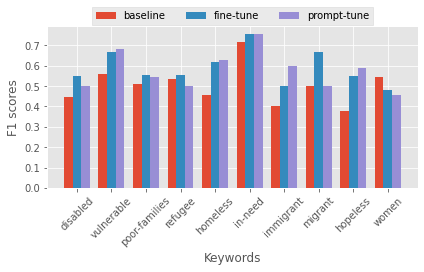

In [ ]:
# data to plot
l_keywords = list(keywords)
n_groups = len(l_keywords)
# {'disabled', 'vulnerable', 'poor-families', 'refugee', 'homeless', 'in-need', 'immigrant', 'migrant', 'hopeless', 'women'}
baseline = [0.4444, 0.5600, 0.5106, 0.5333, 0.4554, 0.7174, 0.4000, 0.5000, 0.3764, 0.5455]
finetune = [0.5517, 0.6667, 0.5556, 0.5556, 0.6176, 0.7532, 0.5000, 0.6667, 0.5500, 0.4828]
prompt   = [0.5000, 0.6818, 0.5455, 0.5000, 0.6269, 0.7568, 0.6000, 0.5000, 0.5882, 0.4545]

# create plot
fig, ax = plt.subplots()
index = np.arange(n_groups)
bar_width = 0.25

rects1 = plt.bar(index, baseline, bar_width, label='baseline')
rects2 = plt.bar(index + bar_width, finetune, bar_width, label='fine-tune')
rects3 = plt.bar(index + 2 * bar_width, prompt, bar_width, label='prompt-tune')

plt.xlabel('Keywords')
plt.ylabel('F1 scores')
plt.xticks(index + bar_width, l_keywords, rotation=45)
# plt.legend(loc=1)
plt.legend(loc='upper center', bbox_to_anchor=(0.5, 1.15),
          fancybox=False, shadow=False, ncol=5)

plt.tight_layout()
plt.savefig("keywords.pdf")

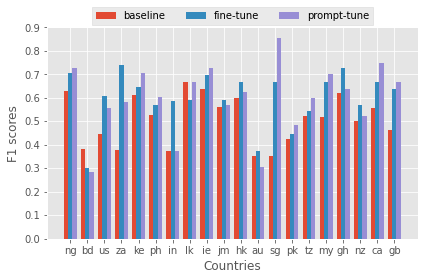

In [ ]:
# data to plot
n_groups = len(countries)
#         {'ng, bd, us, za, ke, ph, in, lk, ie, jm, hk, au, sg, pk, tz, my, gh, nz, ca, gb'}
baseline = [0.6315, 0.3810, 0.4444, 0.3784, 0.6111, 0.5263, 0.3750, 0.6667, 0.64, 0.5625, 0.6, 0.3529, 0.3529, 0.4242, 0.5217, 0.5185, 0.6207, 0.5, 0.5556, 0.4615]
finetune = [0.7058823529411765, 0.3, 0.608695652173913, 0.7407407407407406, 0.6486486486486487, 0.5714285714285715, 0.588235294117647, 0.5925925925925926, 0.6956521739130435, 0.5925925925925927, 0.6666666666666666, 0.37499999999999994, 0.6666666666666666, 0.4444444444444444, 0.5454545454545454, 0.6666666666666667, 0.7272727272727272, 0.5714285714285715, 0.6666666666666665, 0.6363636363636364]
promtp   = [0.7272727272727272, 0.2857142857142857, 0.5555555555555556, 0.5833333333333334, 0.7058823529411765, 0.606060606060606, 0.375, 0.6666666666666666, 0.7272727272727272, 0.5714285714285714, 0.6250000000000001, 0.3076923076923077, 0.8571428571428571, 0.48484848484848486, 0.6, 0.7000000000000001, 0.6363636363636365, 0.5217391304347826, 0.75, 0.6666666666666666]

# create plot
fig, ax = plt.subplots()
index = np.arange(n_groups)
bar_width = 0.25

rects1 = plt.bar(index, baseline, bar_width, label='baseline')
rects2 = plt.bar(index + bar_width, finetune, bar_width, label='fine-tune')
rects3 = plt.bar(index + 2 * bar_width, promtp, bar_width, label='prompt-tune')

plt.xlabel('Countries')
plt.ylabel('F1 scores')
plt.xticks(index + bar_width, countries, rotation=0)
plt.legend(loc='upper center', bbox_to_anchor=(0.5, 1.12),
          fancybox=False, shadow=False, ncol=5)

plt.tight_layout()
plt.savefig("countries.pdf")

# Class Distribution

In [6]:
[len(data[data.orig_label==l]) for l in "01234"]

[6825, 756, 466, 1384, 1012]

In [7]:
len(data[data.label==1]), len(data[data.label==0])

(2862, 7581)

# Create dictionary

Text(0, 0.5, 'Frequency')

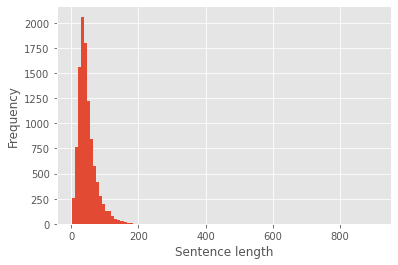

In [8]:
texts = data['text'].astype(str).values.tolist()
texts_tokened = [snt.split() for snt in texts]
texts_len = [len(snt) for snt in texts_tokened]
plt.hist(texts_len, bins=100)
plt.xlabel("Sentence length")
plt.ylabel("Frequency")

In [9]:
print(f"mean sentence length: {np.mean(texts_len)}, max sentence length: {np.max(texts_len)} (at {np.argmax(texts_len)}), min sentence length: {np.min(texts_len)} (at {np.argmin(texts_len)})")
print(np.percentile(texts_len, 98))
data['label'][np.argmax(texts_len)], data['text'][np.argmax(texts_len)]

mean sentence length: 46.34779277985253, max sentence length: 909 (at 7489), min sentence length: 1 (at 2266)
122.0


(0,
 '"Dr Mayengbam Lalit Singh Recently honourable PM of India launched scheme called "" Doubling Farmers \' Income "" in order to uplift the welfare being of larger portion of Indians . The big questions felt by people are ( i ) How would it be possible in short period of time ? And ( ii ) is it an elusive doctrine to sweep vote bank of millions of farmers for upcoming parliamentary election in 2019 ? Across all over India ( except for a few states ) so many rigidities have to be solved in order to raise the real income of farmers . These rigidities are characterised by infrastructures , structures and institutions . The present article focuses on those rigidities only for Manipur which has been lagging behind many Indian states . Regarding infrastructure ( inputs ) , the state is found backward among those backward states of India . Introspecting water infrastructure , the state has been under-utilising water resources despite the abundant availability . For Kharif season crops farm

In [10]:
def get_dict_with_freq(dataframe):
  texts = dataframe['text'].astype(str).values.tolist()
  tokens = " ".join(texts).lower().split()
  tokens_size = len(tokens)
  counts = Counter(tokens)
  print(len(counts), tokens_size)
  frequency = {}
  for w in counts:
    frequency[w] = counts[w] / tokens_size

  return frequency
  
def calculate_keyword_pmi(dataframe):
  word_freqs = get_dict_with_freq(dataframe)
  samples_num = len(dataframe)

  result = {}
  for keyword in keywords:
    print(keyword)
    keyword_df = dataframe[dataframe.keyword == keyword]

    # conditional prob
    word_keyword_freqs = get_dict_with_freq(keyword_df)

    pmis, words = [], []
    for word in word_keyword_freqs:
      words.append(word)
      pmis.append(np.log(word_keyword_freqs[word] / word_freqs[word]))

    result[keyword] = (pmis, words)
  return result

def calculate_country_pmi(dataframe):
  word_freqs = get_dict_with_freq(dataframe)
  samples_num = len(dataframe)

  result = {}
  for country in countries:
    print(country)
    keyword_df = dataframe[dataframe.country == country]

    # conditional prob
    word_keyword_freqs = get_dict_with_freq(keyword_df)

    pmis, words = [], []
    for word in word_keyword_freqs:
      words.append(word)
      pmis.append(np.log(word_keyword_freqs[word] / word_freqs[word]))

    result[country] = (pmis, words)
  return result

# Sentence length

41.5272536687631 48.16765598206042
26.31776052957482 29.18188871271734


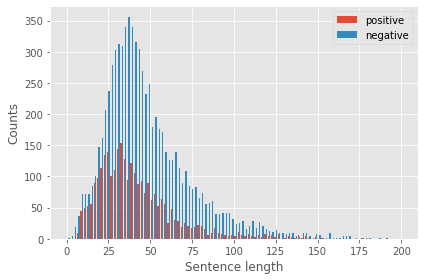

In [11]:
posdf = data[data.label==1]
pos_texts = posdf['text'].astype(str).values.tolist()
pos_texts_tokened = [snt.split() for snt in pos_texts]
pos_texts_len = [len(snt) for snt in pos_texts_tokened]

negdf = data[data.label==0]
neg_texts = negdf['text'].astype(str).values.tolist()
neg_texts_tokened = [snt.split() for snt in neg_texts]
neg_texts_len = [len(snt) for snt in neg_texts_tokened]

print(np.mean(pos_texts_len), np.mean(neg_texts_len))
print(np.std(pos_texts_len), np.std(neg_texts_len))

plt.hist([pos_texts_len, neg_texts_len], bins=100, label=["positive", "negative"], range=(0, 200))
# plt.hist(neg_texts_len, bins=100, alpha=0.5, label="negative")
plt.legend()
plt.xlabel("Sentence length")
plt.ylabel("Counts")
plt.tight_layout()
plt.savefig("sentence-len.pdf")

# Data analysis of positive samples

In [ ]:
posdf = data[data.label==1]
posdf

,par_id,art_id,keyword,country,text,label,orig_label
0,4341,@@17139403,poor-families,gb,"The scheme saw an estimated 150,000 children f...",1,4
1,4136,@@22273328,homeless,za,Durban 's homeless communities reconciliation ...,1,2
2,10352,@@21102155,poor-families,lk,The next immediate problem that cropped up was...,1,4
3,8279,@@21220476,vulnerable,nz,Far more important than the implications for t...,1,2
4,1164,@@14727121,poor-families,gh,To strengthen child-sensitive social protectio...,1,4
...,...,...,...,...,...,...,...
789,873,@@20374243,poor-families,sg,Citing the fact that these kids who died at Go...,1,2
790,10070,@@15573661,disabled,ng,Fern ? ndez was a well-known philanthropist wh...,1,2
791,6484,@@2559173,homeless,lk,"Touched much by their plight , Commanding Offi...",1,2
792,6249,@@1947926,women,gh,She reiterated her ministry 's commitment to p...,1,2


In [ ]:
for k in keywords:
  print(f"{k}: {len(posdf[posdf.keyword==k])}")

for k in countries:
  print(f"{k}: {len(posdf[posdf.country==k])}")

poor-families: 112
homeless: 149
vulnerable: 60
migrant: 31
hopeless: 98
women: 38
disabled: 67
immigrant: 23
refugee: 73
in-need: 143
my: 35
tz: 30
ie: 42
in: 32
au: 32
ph: 52
nz: 35
lk: 40
us: 34
sg: 34
bd: 37
gh: 63
pk: 39
jm: 47
ke: 32
gb: 48
ca: 38
za: 47
ng: 57
hk: 20


90.0


(array([20., 21., 27., 56., 40., 86., 72., 67., 63., 58., 47., 39., 34.,
        26., 29., 12., 21.,  9., 11.,  7.,  8.,  5.,  9.,  7.,  1.,  5.,
         5.,  2.,  3.,  0.,  0.,  0.,  0.,  1.,  0.,  0.,  0.,  0.,  1.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  1.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  1.]),
 array([  6.  ,  11.06,  16.12,  21.18,  26.24,  31.3 ,  36.36,  41.42,
         46.48,  51.54,  56.6 ,  61.66,  66.72,  71.78,  76.84,  81.9 ,
         86.96,  92.02,  97.08, 102.14, 107.2 , 112.26, 117.32, 122.38,
        127.44, 132.5 , 137.56, 142.62, 147.68, 152.74, 157.8 , 162.86,
        167.92, 172.98, 178.04, 183.1 , 188.16, 193.22, 198.28, 203.34,
        208.4 , 213.46, 218.52, 223.58, 228.64, 233.7 , 238.76, 243.82,
  

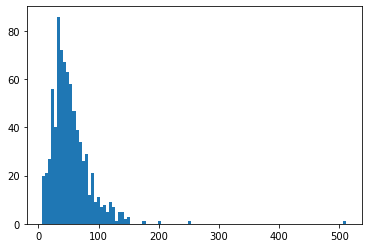

In [ ]:
texts = posdf['text'].astype(str).values.tolist()
texts_tokened = [snt.split() for snt in texts]
texts_len = [len(snt) for snt in texts_tokened]
print(np.percentile(texts_len, 90))
plt.hist(texts_len, bins=100)

In [ ]:
result = calculate_keyword_pmi(posdf)
for keyword in keywords:
  pmis, words = result[keyword]
  values, indices = torch.topk(torch.Tensor(pmis), 100)
  print(f"{keyword}: {np.array(words)[indices]}")

7044 42496
in-need
2125 7953
refugee
1294 3514
poor-families
1789 6105
homeless
2154 7306
disabled
1121 3098
vulnerable
1195 3326
migrant
961 2350
women
812 2028
immigrant
626 1431
hopeless
1774 5385
in-need: ['counts' 'fond' 'cherish' 'mosque' 'medicards' 'selfish' 'retailing'
 'importuned' 'eaten' 'dad' 'kindest' 'ashamed' 'spared' '"another'
 'penny' 'bothered' 'baron' 'earner' 'balkan' 'angels' 'cater'
 'accessibility' 'appointed' 'three-michelin-starred' 'imbued'
 'convenience' 'meets' 'partnering' 'shamefully' 'conscious' 'countrymen'
 'prepares' 'tons' 'familiar' 'vicinity' 'notion' 'filmaid' 'disabused'
 'teachings' 'intervention' 'blessing' 'scriptures' 'massimo' 'caroline'
 'shops' 'jayathilake' 'campbell' 'implement' 'ransilu' 'fairprice'
 'communication' 'subscribe' 'dinu' 'personality' 'weekly' 'dictate'
 'organ' 'newsletter"' '"lakshan' 'transplants' 'madurasinghe' '"dinu'
 'positivity.' 'manne' 'smiles' 'game' 'liz' 'sustainability' 'companies'
 'coca-cola' 'beverages' '

In [ ]:
result = calculate_country_pmi(posdf)
for country in countries:
  pmis, words = result[country]
  values, indices = torch.topk(torch.Tensor(pmis), 100)
  print(f"{country}: {np.array(words)[indices]}")

7044 42496
sg
886 2103
my
702 1791
hk
380 752
lk
1032 2719
ie
740 1804
ca
783 1879
jm
890 2356
ng
1206 3467
pk
998 2458
nz
533 1192
gh
1177 3360
tz
619 1549
au
807 1937
za
946 2395
us
788 1949
in
877 2000
ke
626 1369
ph
1092 2847
bd
891 2071
gb
1018 2498
sg: ['dot' 'fostering' 'selflessly' 'commend' 'marriages' 'strengthening'
 'chuan-jin' 'tan' 'apathetic' 'ms' 'heartened' 'chen' 'serene' 'ocn'
 'principles' 'vicki' 'treadell' 'fundamentally' 'ogp' 'opener' 'ignored'
 'experiencing' 'madhu' 'shoot' 'story"' 'endure' 'adult' 'nevertheless'
 'films' 'manages' 'entirely' 'tulasi' 'krishna' 'thankfully' 'advance'
 'trope' 'maniacal' 'darker' 'weird' 'heroine' '*sigh' 'bullying'
 'disappointing' 'majesty' 'commonwealth' 'points' 'rascals' 'swear'
 'horrifying' 'madhusudhan' 'real-life' 'banning' 'ryan' 'shooting'
 'remainder' '"ryan' 'severe' 'decisions' 'repeatedly' 'shifting' 'chuan'
 'toh' 'manpower' 'bump' '"from' 'competition' 'mexico' 'sneakers'
 'co-founded' 'profit' 'innersole' '$2

#Data analysis of negative samples

In [ ]:
negdf = data[data.label==0]
negdf

,par_id,art_id,keyword,country,text,label,orig_label
794,1,@@24942188,hopeless,ph,"We 're living in times of absolute insanity , ...",0,0
795,2,@@21968160,migrant,gh,"In Libya today , there are countless number of...",0,0
796,3,@@16584954,immigrant,ie,"""White House press secretary Sean Spicer said ...",0,0
797,4,@@7811231,disabled,nz,Council customers only signs would be displaye...,0,0
798,5,@@1494111,refugee,ca,""""""" Just like we received migrants fleeing El ...",0,0
...,...,...,...,...,...,...,...
2089,1459,@@1166455,immigrant,ca,"Walking down the street in Montreal , I am str...",0,0
2090,1460,@@20605972,disabled,ph,The Indians ' two-time All-Star second baseman...,0,0
2091,1461,@@14812450,migrant,hk,Australia currently takes immigrants with a Si...,0,0
2092,1462,@@1193000,migrant,hk,In another sign that labor markets remain rela...,0,0


In [ ]:
for k in keywords:
  print(f"{k}: {len(negdf[negdf.keyword==k])}")

for k in countries:
  print(f"{k}: {len(negdf[negdf.country==k])}")

poor-families: 101
homeless: 122
vulnerable: 149
migrant: 146
hopeless: 110
women: 133
disabled: 120
immigrant: 149
refugee: 137
in-need: 133
my: 81
tz: 41
ie: 75
in: 71
au: 61
ph: 57
nz: 74
lk: 69
us: 76
sg: 74
bd: 73
gh: 54
pk: 73
jm: 40
ke: 60
gb: 63
ca: 65
za: 78
ng: 60
hk: 55


(array([1.670e+02, 4.440e+02, 1.019e+03, 1.485e+03, 1.354e+03, 9.070e+02,
        6.260e+02, 4.700e+02, 3.300e+02, 2.260e+02, 1.700e+02, 9.800e+01,
        1.070e+02, 5.400e+01, 3.400e+01, 2.800e+01, 1.900e+01, 1.700e+01,
        1.200e+01, 5.000e+00, 2.000e+00, 0.000e+00, 0.000e+00, 1.000e+00,
        1.000e+00, 1.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 1.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        1.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 1.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 0.000e+0

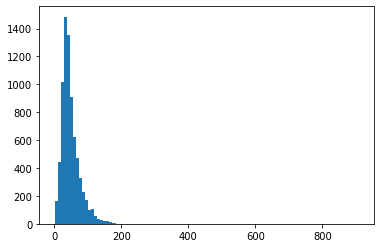

In [ ]:
texts = negdf['text'].astype(str).values.tolist()
texts_tokened = [snt.split() for snt in texts]
texts_len = [len(snt) for snt in texts_tokened]
plt.hist(texts_len, bins=100)

In [ ]:
result = calculate_keyword_pmi(negdf)
for keyword in keywords:
  pmis, words = result[keyword]
  values, indices = torch.topk(torch.Tensor(pmis), 100)
  print(f"{keyword}: {np.array(words)[indices]}")

28406 365159
in-need
6667 34317
refugee
6052 34470
poor-families
5655 30609
homeless
6012 31362
disabled
6817 35555
vulnerable
7290 40694
migrant
7167 39928
women
7588 37886
immigrant
7190 39900
hopeless
7765 40438
in-need: ['ufuoma' 'killarney' 'prodigious' 'neo-colonial' 'traumatise' 'malini'
 'psa' 'deol' 'foodbank' 'popping' 'jaffery' 'caps' 'rehmat' 'mahila'
 'realsport' 'peterson' 'loo' 'nuwan' 'midfielder' 'ape' 'strikers' '6-8'
 "o'loughlin" 'rakai' 'world-record' '"pop' 'bondage' 'refurbishing'
 'comparatively' 'hema' '"sawang' 'replenished' 'inject' 'x5'
 'gunathilaka' 'roland' 'e-commerce' 'tritsch' 'gaffer' "o'brien"
 'karamoja' 'emerges' 'post-brexit' 'mcissac' 'evacuate' 'bukoba' 'pieta'
 'needling' 'perceptible' 'suv' 'gouveia' 'old-school' 'isingiro'
 'saddest' 'shs140billion' '#puertorico' 'unsatisfactory' 'contingency'
 'playmaking' 'trolleys' 'silky' 'western-backed' 'yahapalanaya' 'kiev'
 'isco' 'vruddha' 'boxer' 'insulin' 'sorely' 'smoother' 'kamugisha'
 'queens' '

In [ ]:
result = calculate_country_pmi(negdf)
for country in countries:
  pmis, words = result[country]
  values, indices = torch.topk(torch.Tensor(pmis), 100)
  print(f"{country}: {np.array(words)[indices]}")

28406 365159
sg
4583 18369
my
3992 15337
hk
4472 17773
lk
5169 23344
ie
4416 17875
ca
4575 18643
jm
3832 16055
ng
4498 19186
pk
4953 21833
nz
4116 16737
gh
4097 17029
tz
3042 11844
au
4534 18428
za
4449 18055
us
5378 23536
in
5381 22087
ke
4084 16536
ph
4606 18635
bd
3960 16469
gb
4375 17388
sg: ['vinta' 'kampot' 'alindajao' 'crewman' '"filipino' '"nhs' 'consultants'
 'pathogenic' 'orchestra' 'khushbu' 'cancellations' 'zero-tolerance'
 'aluminum' 'bokor' 'shakedowns' 'cage' 'sandhya' 'reservation'
 'plaintiffs' 'lachlan' 'murdoch' 'headquartered' 'embattled'
 'moroccan-born' 'buraika' 'robot' 'upside' 'medina' 'ayatollah'
 'khomeini' "shari'ah" 'suisse' 'second-class' 'ul-haq' 'removes'
 'translators' 'spd' 'surging' 'aboutaleb' '911' 'neurological' 'schrock'
 'dosimeter' 'casualties' 'thermometer' '$68,000' 'sub-decree'
 'interviewer' '1,288' 'toh' 'sub-zero' 'reshuffle' 'faults' 'analyses'
 'smrt' 'jeshi' 'soby' 'sofy' 'cuddle' 'applauds' 'iwl' 'aiff' 'praful'
 'sds' 'emerson' 'greas